[View in Colaboratory](https://colab.research.google.com/github/saquibntt/TensorFlow-Examples/blob/master/TensorFlow_Issue_16465.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
!pip install librosa
import librosa

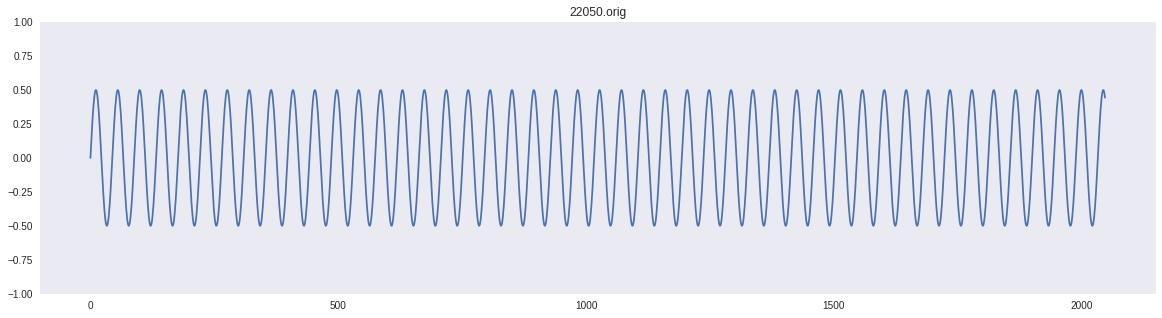

--------------------------------------------------------------------------------
tensorflow.22050.stft.l1024.s256


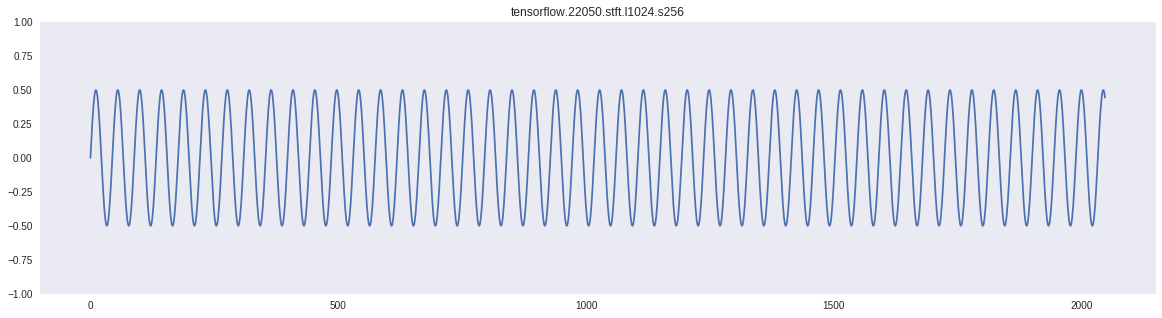

--------------------------------------------------------------------------------
tensorflow.22050.stft.l1024.s512


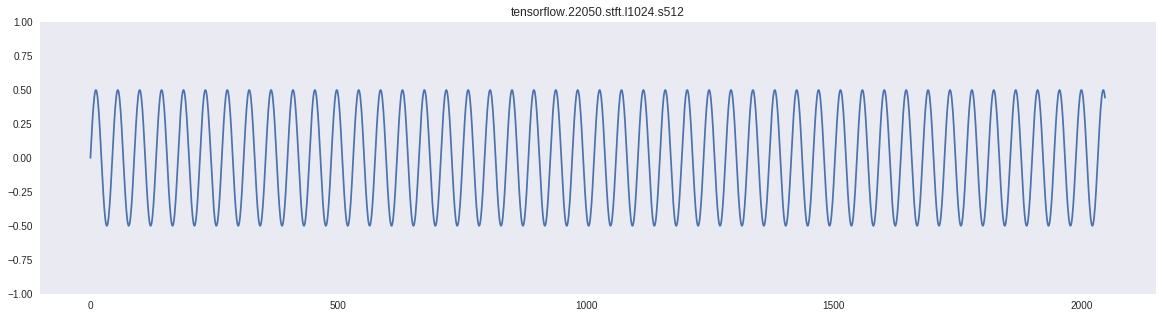

--------------------------------------------------------------------------------
tensorflow.22050.stft.l1024.s768


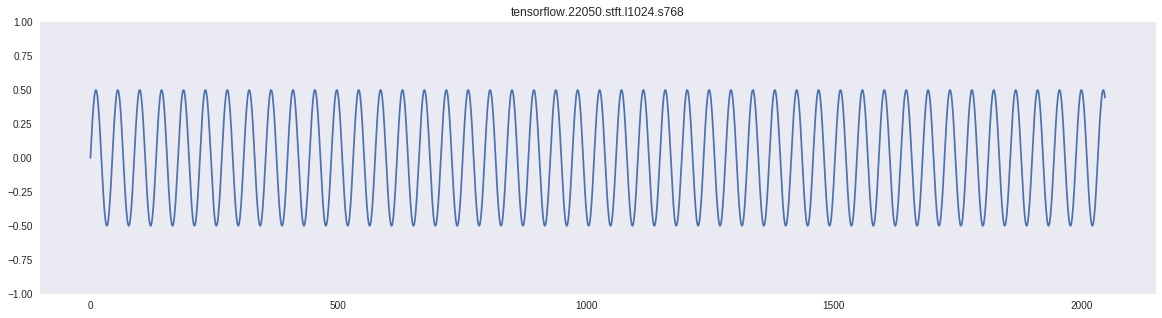

--------------------------------------------------------------------------------
tensorflow.22050.stft.l1024.s1024


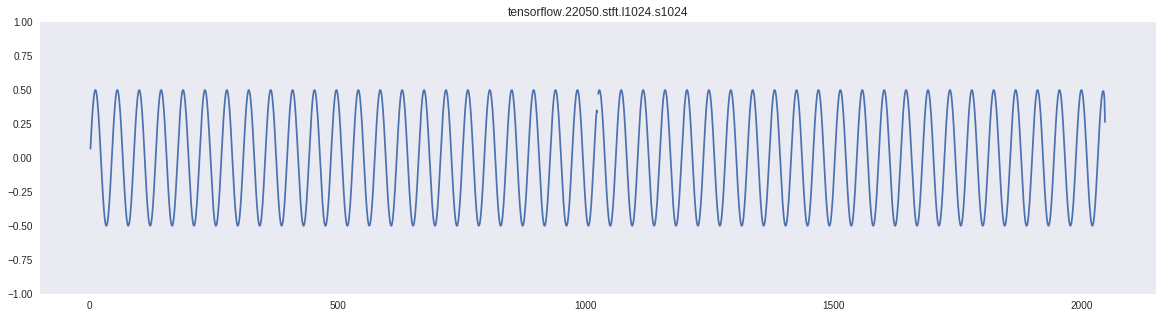

done.


In [0]:
from __future__ import print_function
from __future__ import division

import functools
import numpy as np
import scipy.io.wavfile
import math
import random
import matplotlib.pyplot as plt

import tensorflow as tf
out_prefix = 'tensorflow'


def plot(data, title, do_save=True):
    plt.figure(figsize=(20,5))
    plt.plot(data[:2*frame_length])
    plt.ylim([-1, 1])
    plt.title(title)
    plt.grid()
    if do_save: plt.savefig(title + '.png')
    plt.show()


def reconstruct_from_frames(x, frame_length, frame_step):
    name = 'frame'
    frames_T = tf.contrib.signal.frame(x, frame_length=frame_length, frame_step=frame_step, pad_end=False)
    windowed_frames_T = frames_T * tf.contrib.signal.hann_window(frame_length, periodic=True)
    output_T = tf.contrib.signal.overlap_and_add(windowed_frames_T, frame_step=frame_step)
    return name, output_T


def reconstruct_from_stft(x, frame_length, frame_step):
    name = 'stft'
    #spectrograms_T = tf.contrib.signal.stft(x, frame_length, frame_step)
    center = True
    if center:
      pad_amount = 2 * (frame_length - frame_step)
      x = tf.pad(x, [[pad_amount // 2, pad_amount // 2]], 'REFLECT')
    
    f = tf.contrib.signal.frame(x, frame_length, frame_step, pad_end=False)
    w = tf.contrib.signal.hann_window(frame_length, periodic=True)
    spectrograms_T = tf.spectral.rfft(f * w, fft_length=[frame_length])
        
    output_T = tf.contrib.signal.inverse_stft(spectrograms_T, frame_length, frame_step,
                                              window_fn=tf.contrib.signal.inverse_stft_window_fn(frame_step, functools.partial(tf.contrib.signal.hann_window, periodic=True)))
    if center and pad_amount > 0:
      output_T = output_T[pad_amount // 2:-pad_amount // 2]
    return name, output_T


def test(fn, input_data):
    print('-'*80)
    tf.reset_default_graph()
    input_T = tf.placeholder(tf.float32, [None]) 
    name, output_T = fn(input_T, frame_length, frame_step)

    title = "{}.{}.{}.l{}.s{}".format(out_prefix, sample_rate, name, frame_length, frame_step)
    print(title)

    with tf.Session():
        output_data =  output_T.eval({input_T:input_data})

#    output_data /= frame_length/frame_step/2 # tensorflow needs this to normalise amp
    plot(output_data, title)
    #scipy.io.wavfile.write(title+'.wav', sample_rate, output_data)


def generate_data(duration_secs, sample_rate, num_sin, min_freq=10, max_freq=500, rnd_seed=0, max_val=0):
    '''generate signal from multiple random sin waves'''
    if rnd_seed>0: random.seed(rnd_seed)
    data = np.zeros([duration_secs*sample_rate], np.float32)
    for i in range(num_sin):
        w = np.float32(np.sin(np.linspace(0, math.pi*2*random.randrange(min_freq, max_freq), num=duration_secs*sample_rate)))
        data += random.random() * w
    if max_val>0:
        data *= max_val / np.max(np.abs(data))
    return data
    

frame_length = 1024
sample_rate = 22050

input_data = generate_data(duration_secs=1, sample_rate=sample_rate, num_sin=1, rnd_seed=2, max_val=0.5)

title = "{}.orig".format(sample_rate)
plot(input_data, title)
#scipy.io.wavfile.write(title+'.wav', sample_rate, input_data)

for frame_step in [256, 512, 768, 1024]:
    #test(reconstruct_from_frames, input_data)
    test(reconstruct_from_stft, input_data)

print('done.')